In [35]:
import meshio
import numpy as np
from dolfinx import mesh, fem
from mpi4py import MPI
import basix
import pyvista as pv
from dolfinx.io import XDMFFile

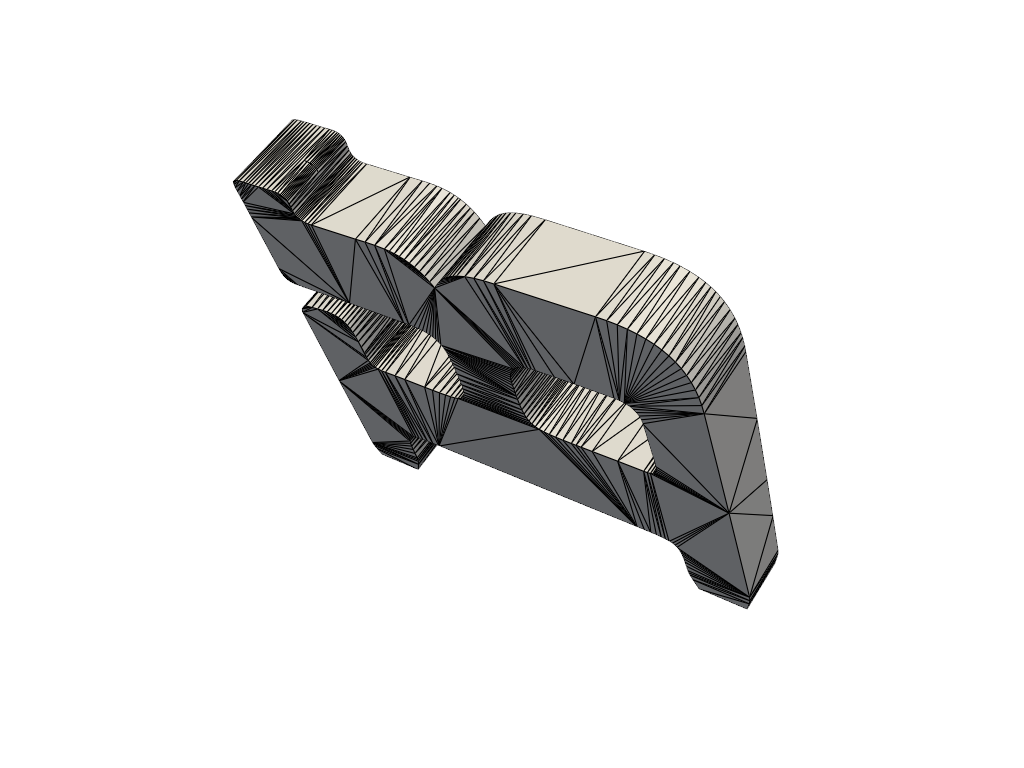

In [36]:
# Read STL
input_stl = "test.stl"
mesh_data = meshio.read(input_stl)

points = mesh_data.points
cells = mesh_data.cells_dict.get("triangle")

# PyVista
if cells is not None:
    n_cells = cells.shape[0]
    cell_data = np.hstack([np.full((n_cells, 1), 3), cells]).flatten()
else:
    raise ValueError("No triangular cells found in the mesh.")


pv_mesh = pv.PolyData(points, cell_data)
plotter = pv.Plotter()
plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.show()

In [37]:
# XDMF
xdmf_file = "converted_mesh.xdmf"
meshio.write(xdmf_file, mesh_data)

# Load into DOLFINx
with XDMFFile(MPI.COMM_WORLD, xdmf_file, "r") as xdmf:
    domain_mesh = xdmf.read_mesh(name="Grid")

In [45]:
from mpi4py import MPI

# Get the bounds of the mesh

# Translate the mesh to align with the laser domain
domain_mesh.geometry.x[:, 0] += 5  # Adjust X to move into range [0, 1]
domain_mesh.geometry.x[:, 1] -= 28  # Adjust Y to range around 0.0
domain_mesh.geometry.x[:, 2] += 29  # Adjust Z to range around 0.0


x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh bounds:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


Mesh bounds:
X: [0.16219806671142578, 0.5886878967285156]
Y: [-0.19614028930664062, 0.6003570556640625]
Z: [-0.14744186401367188, 0.5462665557861328]


In [50]:
# Temperature function space (scalar field)
element_temp = basix.ufl.element("Lagrange", domain_mesh.topology.cell_name(), degree=1)
V_T = fem.functionspace(domain_mesh, element_temp)

In [48]:
import ufl
import numpy as np
from dolfinx.fem.petsc import LinearProblem

# Trial and test functions for temperature
T = ufl.TrialFunction(V_T)
v_T = ufl.TestFunction(V_T)

# Thermal conductivity, heat source
Q = fem.Function(V_T)  # Heat source (moving laser in LBPF)
rho = 7800  # Density
cp = 500  # Specific heat capacity
k = 45  # Thermal conductivity

# Boundary conditions for temperature
T_bc = fem.Function(V_T)
T_bc.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Fixed boundary temperature
boundary_facets_T = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs_T = fem.locate_dofs_topological(V_T, domain_mesh.topology.dim - 1, boundary_facets_T)
bc_T = fem.dirichletbc(T_bc, boundary_dofs_T)

# Initialize temperature solution and previous temperature field
T_sol_moving = fem.Function(V_T)  # Current solution
T_prev = fem.Function(V_T)  # Previous step solution (initial condition)
T_prev.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Initial temperature (300 K)

# Define the moving Gaussian heat source
def moving_gaussian_heat_source(x, t):
    # Laser path: moves in the x-direction over time
    center = np.array([0.1 + 0.05 * t, 0.5, 0.0])  # Starting at (0.1, 0.5, 0.0)
    intensity = 1e6  # Heat intensity (W/m^3)
    radius = 0.1  # Laser radius (m)
    r = np.linalg.norm(x - center[:, np.newaxis], axis=0)  # Distance from moving center
    result = intensity * np.exp(-r**2 / (2 * radius**2))  # Gaussian distribution
    
    # print(f"Center: {center}, x: {x}, r: {r}, Q: {result}")
    return result

# Time-stepping parameters
t_start = 0.0
t_end = 10.0  # Total simulation time
dt = 0.1      # Time step size
num_steps = int((t_end - t_start) / dt)

# Time-stepping loop
for step in range(num_steps):
    t = t_start + step * dt  # Current time

    # Update the heat source for the current time step
    Q.interpolate(lambda x: moving_gaussian_heat_source(x, t))

    # Update weak form for transient heat equation
    a_T = rho * cp * T * v_T * ufl.dx + k * ufl.dot(ufl.grad(T), ufl.grad(v_T)) * ufl.dx
    L_T = rho * cp * T_prev * v_T * ufl.dx + Q * v_T * ufl.dx  # Use previous temperature

    # Solve for the current temperature field
    temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
    T_sol_moving = temp_problem.solve()

    # Update T_prev for the next time step
    T_prev.x.array[:] = T_sol_moving.x.array[:]

# print(f"Max Q: {Q.x.array.max()}")
# print(f"Min Q: {Q.x.array.min()}")

# # Test with a fixed position and time
# test_x = np.array([[0.1, 0.2, 0.3], [0.5, 0.5, 0.5], [0.0, 0.0, 0.0]])  # Sample points
# test_t = 0.0  # Initial time
# q_values = moving_gaussian_heat_source(test_x, test_t)

# print("Test Gaussian Heat Source:", q_values)  # Should show non-zero values



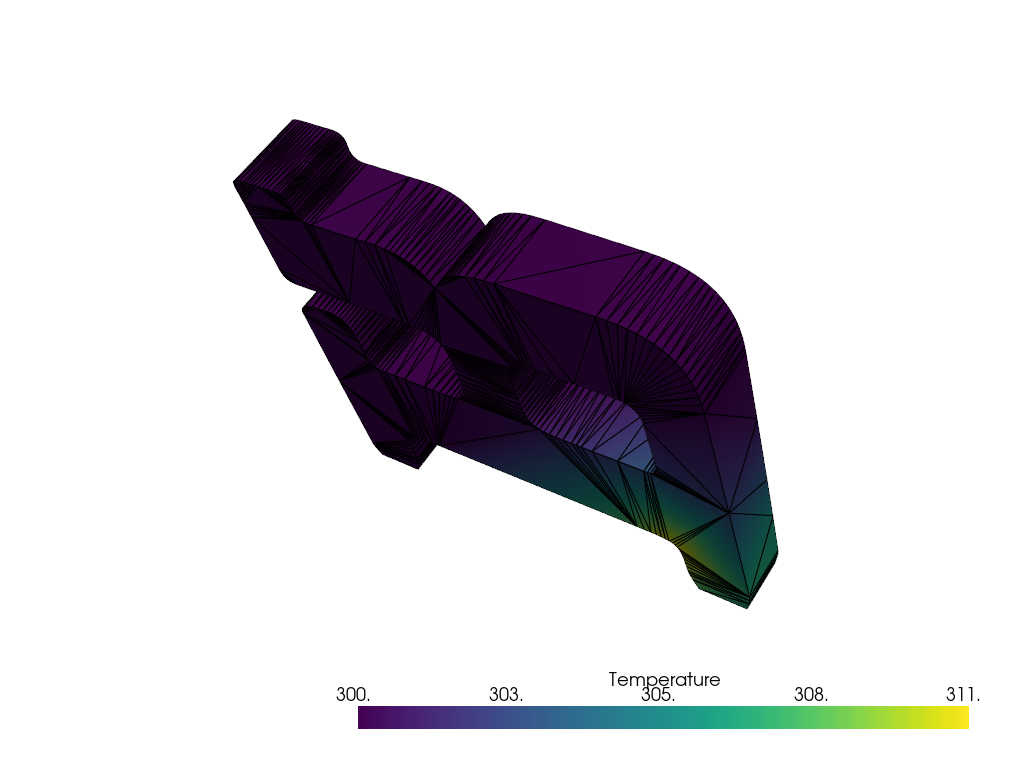

Max Temperature: 310.91048158986416
Min Temperature: 299.8535102730689


In [49]:
import pyvista as pv
from dolfinx.plot import vtk_mesh

# Visualize
topology, cell_types, geometry = vtk_mesh(domain_mesh)

grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add displacement
grid.point_data["Temperature"] = T_sol_moving.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Plot field
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="Temperature", cmap="viridis")
plotter.show()

print(f"Max Temperature: {T_sol_moving.x.array.max()}")
print(f"Min Temperature: {T_sol_moving.x.array.min()}")


In [12]:
# convert to lagrange element
element = basix.ufl.element(
    "Lagrange", domain_mesh.topology.cell_name(), degree=1, shape=(domain_mesh.geometry.dim,)
)

# displacement function
V = fem.functionspace(domain_mesh, element)

In [21]:
import ufl
import numpy as np
from petsc4py import PETSc

# Define the finite element for displacement (vector field)
element_disp = basix.ufl.element(
    "Lagrange", domain_mesh.topology.cell_name(), degree=1, shape=(domain_mesh.geometry.dim,)
)

# Define the function space for displacement
V_u = fem.functionspace(domain_mesh, element_disp)

# Define trial and test functions for displacement
u = ufl.TrialFunction(V_u)  # Trial function (solution approximation for displacement)
v_u = ufl.TestFunction(V_u)  # Test function (used in weak form)

In [ ]:
# Mechanical properties
E = 210e9   # Young's modulus (Pa)
nu = 0.3    # Poisson's ratio
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# Define strain and stress tensors
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Strain tensor

def sigma(u):
    return (
        lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u)) +
        2 * mu * epsilon(u)
    )


In [15]:
# 6. Weak Forms
# Heat transfer weak form
Q = fem.Function(V_T)  # Laser heat source (to be defined later)
a_T = rho * cp * T * v_T * ufl.dx + k * ufl.dot(ufl.grad(T), ufl.grad(v_T)) * ufl.dx
L_T = Q * v_T * ufl.dx



In [16]:
# Set up boundary conditions
# 1. Temperature Dirichlet BC (fixed temperature at x=0)
T_bc = fem.Function(V_T)
T_bc.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Fixed temperature at 300K
boundary_facets_T = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs_T = fem.locate_dofs_topological(V_T, domain_mesh.topology.dim - 1, boundary_facets_T)
bc_T = fem.dirichletbc(T_bc, boundary_dofs_T)

# 2. Displacement Dirichlet BC (fix displacement at x=0)
u_bc = fem.Function(V_u)
u_bc.interpolate(lambda x: np.zeros((domain_mesh.geometry.dim, x.shape[1])))  # Zero displacement
boundary_facets_u = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs_u = fem.locate_dofs_topological(V_u, domain_mesh.topology.dim - 1, boundary_facets_u)
bc_u = fem.dirichletbc(u_bc, boundary_dofs_u)

In [ ]:

# Material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio

# Lame parameters
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# Define strain and stress
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Strain tensor

def sigma(u, T=None):
    # Optionally include thermal expansion from temperature (coupling)
    if T is not None:
        alpha = 12e-6  # Thermal expansion coefficient
        T_ref = 300.0  # Reference temperature
        return (
            lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u))
            + 2 * mu * epsilon(u)
            - alpha * E * (T - T_ref) * ufl.Identity(len(u))
        )
    return lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


In [20]:
# Solve Temperature
from dolfinx.fem.petsc import LinearProblem

# Solve temperature field
temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
T_sol = temp_problem.solve()


T_expr = fem.Function(V_T)
T_expr.x.array[:] = T_sol.x.array[:]

# Elasticity weak form (temperature-dependent stress)
f = fem.Constant(domain_mesh, PETSc.ScalarType((0.0, 0.0, -9.81)))  # Body force
a_u = ufl.inner(sigma(u, T_expr), epsilon(v_u)) * ufl.dx
L_u = ufl.inner(f, v_u) * ufl.dx


# Solve Displacement
disp_problem = LinearProblem(a_u, L_u, bcs=[bc_u])
u_disp = disp_problem.solve()

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
import pyvista as pv
from dolfinx.plot import create_vtk_mesh

# Create the VTK mesh for visualization
topology, cell_types, geometry = create_vtk_mesh(domain_mesh)

# Initialize a PyVista UnstructuredGrid
grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add the displacement field to the mesh
grid.point_data["Displacement"] = u_disp.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Add the temperature field to the mesh
grid.point_data["Temperature"] = T_sol.x.array  # Direct assignment for scalar fields

# Create a plotter
plotter = pv.Plotter()

# Plot the displacement field
plotter.add_mesh(grid.copy(), scalars="Displacement", show_edges=True, cmap="coolwarm")
plotter.add_scalar_bar(title="Displacement Magnitude")

# Plot the temperature field on the same grid
plotter.add_mesh(grid.copy(), scalars="Temperature", show_edges=False, cmap="viridis")
plotter.add_scalar_bar(title="Temperature")

# Show the plot
plotter.show()


In [6]:
# Define trial and test functions
u = ufl.TrialFunction(V)  # Displacement field
v = ufl.TestFunction(V)

# Body force (e.g., gravity in z-direction)
f = fem.Constant(domain_mesh, PETSc.ScalarType((0.0, 0.0, -9.81)))

# Weak form
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx 

In [7]:
# Boundary conditions
u_bc = fem.Function(V)
u_bc.interpolate(lambda x: np.zeros((domain_mesh.geometry.dim, x.shape[1])))

boundary_facets = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs = fem.locate_dofs_topological(V, domain_mesh.topology.dim - 1, boundary_facets)
bc = fem.dirichletbc(u_bc, boundary_dofs)

In [8]:
# Solve
from dolfinx.fem.petsc import LinearProblem

problem = fem.petsc.LinearProblem(a, L, bcs=[bc])
u_sol = problem.solve()

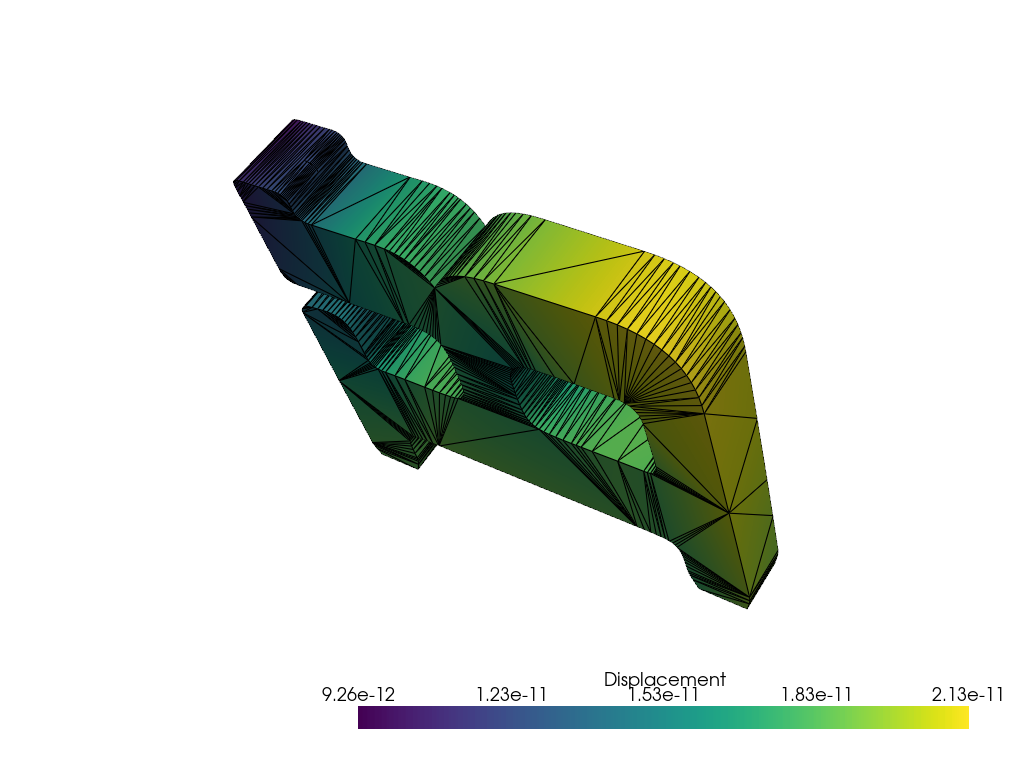

In [9]:
import pyvista as pv
from dolfinx.plot import vtk_mesh

# Visualize
topology, cell_types, geometry = vtk_mesh(domain_mesh)

grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add displacement
grid.point_data["Displacement"] = u_sol.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Plot field
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="Displacement", cmap="viridis")
plotter.show()